In [55]:
from rdkit.Chem import Descriptors
from sklearn.datasets import load_diabetes
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, make_scorer
from sklearn.ensemble import IsolationForest
from collections import Counter
import pickle
from sklearn.feature_selection import SelectKBest, f_regression, GenericUnivariateSelect, VarianceThreshold
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import warnings
import shutup
from contextlib import redirect_stdout
import io
from rdkit import RDLogger 
import numpy as np

In [3]:



# X,y = load_diabetes(return_X_y=True)
# #print(load_diabetes().DESCR)

# #Random Forest
# fpl = Pipeline([
#     ("scale", StandardScaler()),
#     ("model", RandomForestRegressor())
# ])
# # fmodel = fpl.fit(X,y)
# fpred = fmodel.predict(X)
# plt.scatter(fpred,y, color = 'green')


#KNeighbours
# knpl = Pipeline([
#     ("scale", StandardScaler()),
#     ("model", KNeighborsRegressor())
# ])
# model = knpl.fit(X,y)
# prediction = model.predict(X)
# plt.scatter(prediction,y, color = 'red')

#fpred is a lot better, more linear which means it is more consistent with the original targets
#The models above were used to predict the same data that they were trained upon
#--------------------------------------------------------------------------------------------------
#Now, I will attempt to train both models on half the data set, then predict the other half, and then plot those predictions against the targets, much like what I think cross validation is

#Random Forest
# truefmodel = fpl.fit(X[:221],y[:221])
# truefpred = truefmodel.predict(X[-221:])
# plt.scatter(truefpred,y[-221:],color = 'green')

# #KNeighbours
# truekmodel = knpl.fit(X[:221],y[:221])
# truekpred = truekmodel.predict(X[-221:])
# plt.scatter(truekpred,y[-221:], color = 'red')

#Have just now become aware of a train_test_split function that wouldve done this for me


#Now we see that they really arent all that much different without hyperparameter tuning. Random Forest was just a lot better at predicting when it is predicting the data that it was trained on
#This was a sort of half baked two fold cross validation that was done manually
#----------------------------------------------------------------------------------------------------------------
#Now I will perform cross validation how it is intended

#fpl.get_params()
# gridmodel = GridSearchCV(estimator = fpl,
#                          param_grid = {
#                              'model__n_estimators':[25,50,75,100,125,150,200], #Num of trees, decision makers
#                              'model__max_depth':[1,2,3,4,5,6,7,8,9,10] #Num of decisions made by each tree
                              
#                          },
#                          scoring = {'precision':make_scorer(precision_score), 'recall':make_scorer(recall_score)},
#                          refit = 'precision',
#                          cv = 3,
#                          n_jobs = -1)

# gridmodel.fit(X,y)
# data = pd.DataFrame(gridmodel.cv_results_) 
#print(data.loc[data['mean_test_score'].idxmax()])

#For Outliers
# outl = IsolationForest().fit(X)
# print(Counter(outl.predict(X)))
#70 Outliers, a large chunk of data


#The above takes forever to run
#----------------------------------------------------------------------------------------------------------------
#I do want to become familiar with train test split, so will play around with that
#Random Split
#X_train, X_temp, Y_train, Y_temp = train_test_split(X,y,test_size = 0.2,random_state = 42, test_size = 0.2 #20% of the data will be used for testing
                                                    #)
#Further split the testing set into validation and actual testing, with validation being for fine tuning
#How do i do that
#COME BACK TO THIS





In [39]:
%%capture output
with open('./database.pickle', 'rb') as f:
    data = pickle.load(f)

df = pd.DataFrame(data).transpose()


def bemis_murcko_scaffold(smiles, retasmol):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    if retasmol:
        return scaffold
    else :
        return Chem.MolToSmiles(scaffold)
df['Scaffold'] = df['smiles'].apply(bemis_murcko_scaffold, args=(True,))
dfm = df[[ 'iupac', 'smiles','Scaffold', 'calc_h']].copy()



#print(df.head())

#Prints columns as nums but types are objects, so fixing that
# for column in df.columns:
#     if df[column].dtype == 'object':
#         df[column] = pd.to_numeric(df[column], errors='coerce')
#<FEATURIZATION /> -------






dfm.reset_index(drop=True, inplace=True)
dfm['calc_h'] = pd.to_numeric(dfm['calc_h'], errors='coerce')

def getMolDescriptors(mol, missingVal=None):
    RDLogger.DisableLog('rdApp.*') #OH MY GOD THIS WORKSSSSSSS
    res = {}
    output = io.StringIO()
    with redirect_stdout(output):
            for nm,fn in Descriptors.descList:
                if hasattr(fn, '__deprecated__') and fn.__deprecated__:
                    print(f"Skipping deprecated descriptor function: {nm}")
                    continue
                    # some of the descriptor fucntions can throw errors if they fail, catch those here:
                try:
                        val = fn(mol)
                except:
                        # print the error message:
                    
                        # and set the descriptor value to whatever missingVal is
                    val = missingVal
                res[nm] = val
    return res

In [40]:



dfm['mol'] = dfm['smiles'].apply(Chem.MolFromSmiles)
allDescs = dfm['mol'].apply(getMolDescriptors)
descdf = pd.DataFrame(allDescs.tolist(), index=dfm.index)

# Merge descdf with dfm
dfm = pd.concat([dfm, descdf], axis=1)
columns_to_drop = ['iupac','smiles','Scaffold','mol']



# Drop the identified columns
testingdf = dfm.drop(columns=columns_to_drop)
testingdf = testingdf.select_dtypes(include=[np.number])
pd.set_option('display.max_rows', None)
print(testingdf.iloc[0])


# Now dfm should contain all descriptors as columns





calc_h                      -22.379096
MaxAbsEStateIndex            10.730617
MaxEStateIndex               10.730617
MinAbsEStateIndex             0.084877
MinEStateIndex               -1.162639
qed                           0.834381
SPS                           9.769231
MolWt                       221.039000
HeavyAtomMolWt              214.991000
ExactMolWt                  219.969399
NumValenceElectrons          70.000000
NumRadicalElectrons           0.000000
MaxPartialCharge              0.340580
MinPartialCharge             -0.494225
MaxAbsPartialCharge           0.494225
MinAbsPartialCharge           0.340580
FpDensityMorgan1              1.384615
FpDensityMorgan2              1.923077
FpDensityMorgan3              2.307692
BCUT2D_MWHI                  35.496787
BCUT2D_MWLOW                 10.174950
BCUT2D_CHGHI                  2.174419
BCUT2D_CHGLO                 -2.071743
BCUT2D_LOGPHI                 2.329519
BCUT2D_LOGPLOW               -2.013819
BCUT2D_MRHI              

In [41]:
# Function to compute Bemis-Murcko scaffold




# print(df.head())
# image = Draw.MolToImage(df.at[df.index[3],'Scaffold'])
# image.show()




#No duplicate scaffolds
unique = dfm['Scaffold'].unique()

#---------------------
# X = df.drop(columns=['calc_h'])
# Y = df['calc_h']
#---------------------


#Seperate training and testing scaffolds
train_scaff, test_scaff = train_test_split(unique,test_size= 0.2, random_state=42)
#Convert scaffolds back into molecules
# train_data = dfm[dfm['Scaffold'].isin(train_scaff)]
# test_data = dfm[dfm['Scaffold'].isin(test_scaff)]
# #Pipeline wont work with objects and the scaffold was only needed for splitting
# #<FEATURIZATION> ----------
# smilescol = dfm['smiles']
# X_train = train_data.drop(columns=['calc_h'])
# y_train = train_data['calc_h']
# 
# X_test = test_data.drop(columns=['calc_h'])
# y_test = test_data['calc_h']
train_indices = dfm[dfm['Scaffold'].isin(train_scaff)].index
test_indices = dfm[dfm['Scaffold'].isin(test_scaff)].index

# Extract the corresponding rows from testingdf
train_data = testingdf.loc[train_indices]
test_data = testingdf.loc[test_indices]


X_train = train_data.drop(columns=['calc_h'])
y_train = train_data['calc_h']

X_test = test_data.drop(columns=['calc_h'])
y_test = test_data['calc_h']

print(X_train.iloc[0])
print(X_test.iloc[0])


MaxAbsEStateIndex            10.730617
MaxEStateIndex               10.730617
MinAbsEStateIndex             0.084877
MinEStateIndex               -1.162639
qed                           0.834381
SPS                           9.769231
MolWt                       221.039000
HeavyAtomMolWt              214.991000
ExactMolWt                  219.969399
NumValenceElectrons          70.000000
NumRadicalElectrons           0.000000
MaxPartialCharge              0.340580
MinPartialCharge             -0.494225
MaxAbsPartialCharge           0.494225
MinAbsPartialCharge           0.340580
FpDensityMorgan1              1.384615
FpDensityMorgan2              1.923077
FpDensityMorgan3              2.307692
BCUT2D_MWHI                  35.496787
BCUT2D_MWLOW                 10.174950
BCUT2D_CHGHI                  2.174419
BCUT2D_CHGLO                 -2.071743
BCUT2D_LOGPHI                 2.329519
BCUT2D_LOGPLOW               -2.013819
BCUT2D_MRHI                   6.364679
BCUT2D_MRLOW             

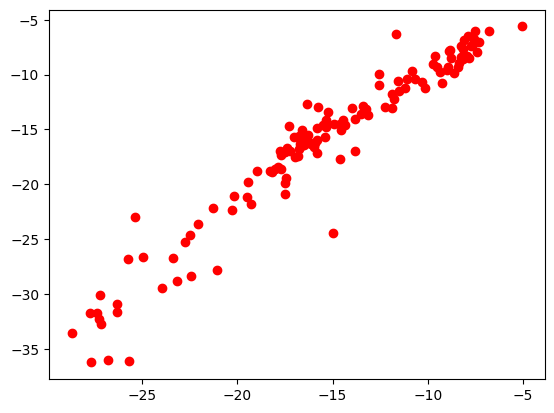

In [43]:
pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("feature_selection", SelectKBest(score_func=f_regression, k = 100)),
    ("model", RandomForestRegressor())
])
model = pipeline.fit(X_train,y_train)
prediction = model.predict(X_test)
plt.scatter(prediction,y_test, color = 'red')
#First graph lets GOOOO!!!

In [50]:


GUS_pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("feature_selection", GenericUnivariateSelect()),
    ("model", RandomForestRegressor())
])

grid_search = GridSearchCV(
    estimator = GUS_pipeline,
    param_grid = {
    'feature_selection__mode': ['fpr', 'percentile', 'k_best'],  # Modes for GenericUnivariateSelect
    'feature_selection__param': [1,5,10, 20, 30],  # Number of features to select (for 'percentile') or the k-best (for 'f_value')
    'model__n_estimators': [50, 100, 200],  # Number of trees in RandomForestClassifier
    'model__max_depth': [None, 10, 20, 30]
    },
    cv=5,
    n_jobs = -1
)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
"""
Best Parameters: {'feature_selection__mode': 'percentile', 'feature_selection__param': 30, 'model__max_depth': 10, 'model__n_estimators': 100}
Best Score: 0.7951393409128509
"""


C:\Users\iirfan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
300 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\iirfan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\iirfan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\iirfan

Best Parameters: {'feature_selection__mode': 'percentile', 'feature_selection__param': 30, 'model__max_depth': 10, 'model__n_estimators': 100}
Best Score: 0.7951393409128509


In [54]:
VAR_pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("feature_selection", VarianceThreshold()),
    ("model", RandomForestRegressor())
])

grid_search = GridSearchCV(
    estimator = VAR_pipeline,
    param_grid = {
    'feature_selection__threshold': [0,0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8],  
    
    'model__n_estimators': [50, 100, 200],  # Number of trees in RandomForestClassifier
    'model__max_depth': [None, 10, 20, 30,35,40,50,60]
    },
    cv=5,
    n_jobs = -1,
    verbose = 2,
)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
"""
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'feature_selection__threshold': 0.5, 'model__max_depth': 30, 'model__n_estimators': 50}
Best Score: 0.8618018395445434
"""

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters: {'feature_selection__threshold': 0.5, 'model__max_depth': 30, 'model__n_estimators': 50}
Best Score: 0.8618018395445434


"\nFitting 5 folds for each of 144 candidates, totalling 720 fits\nBest Parameters: {'feature_selection__threshold': 0.1, 'model__max_depth': 30, 'model__n_estimators': 50}\nBest Score: 0.8582258642217259\n"

In [62]:
VAR_pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("feature_selection", VarianceThreshold()),
    ("model", RandomForestRegressor())
])

mean_squared_scorer = make_scorer(mean_squared_error, greater_is_better = False) #an error function needs to be as small as possible
grid_search = GridSearchCV(
    estimator = VAR_pipeline,
    param_grid = {
    'feature_selection__threshold': [0,0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8],  
    
    'model__n_estimators': [50, 100, 200],  
    'model__max_depth': [None, 10, 20, 30,35,40,50,60],
    'model__max_features': ['auto', 'sqrt', 'log2',5,10,None],
    'model__bootstrap': [True, False],
    },
    cv=4,
    n_jobs = -1,
    verbose = 3,
    scoring = mean_squared_scorer,
)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("Best Mean Squared Error:", -grid_search.best_score_)
"""
Best Parameters: {'feature_selection__threshold': 0.7, 'model__bootstrap': False, 'model__max_depth': 40, 'model__max_features': 'sqrt', 'model__n_estimators': 50}
Best Score: -3.6375138593773655
Best Mean Squared Error: 3.6375138593773655
"""

Fitting 4 folds for each of 3456 candidates, totalling 13824 fits


C:\Users\iirfan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2304 fits failed out of a total of 13824.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
811 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\iirfan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\iirfan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\iir

Best Parameters: {'feature_selection__threshold': 0.7, 'model__bootstrap': False, 'model__max_depth': 40, 'model__max_features': 'sqrt', 'model__n_estimators': 50}
Best Score: -3.6375138593773655
Best Mean Squared Error: 3.6375138593773655


"\nFitting 5 folds for each of 288 candidates, totalling 1440 fits\nBest Parameters: {'feature_selection__threshold': 0.2, 'model__max_depth': 60, 'model__n_estimators': 50}\nBest Score: -4.3949612588425016\nBest Mean Squared Error: 4.3949612588425016\n"